# CNN for Alzheimer's disease detection

The CNN is trained to detect Alzheimer's disease. Given an MRI image of the brain, the CNN can classify it in one for the following classes based on severity  
1. MildDemented
2. VeryMildDemented
3. NonDemented
4. ModerateDemeneted
   
It is trained on "Alzheimer MRI Preprocessed Dataset" dataset from [kaggle](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data) which contains total of 6400 images for 4 severity classes.

## Clone source code repository

In [ ]:
! git clone https://github.com/svghadi/simple-cnn.git
! cd simple-cnn
! pwd

## Import deps

In [1]:
import os, sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
import PIL 
from pathlib import Path
import random
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

## Dataset

The alzheimer's dataset from kaggle is downloaded and extracted in `datasets/alherimers` folder in the source code repository. The dataset is structured in below manner. Images for each severity class are present in their individual folders. 

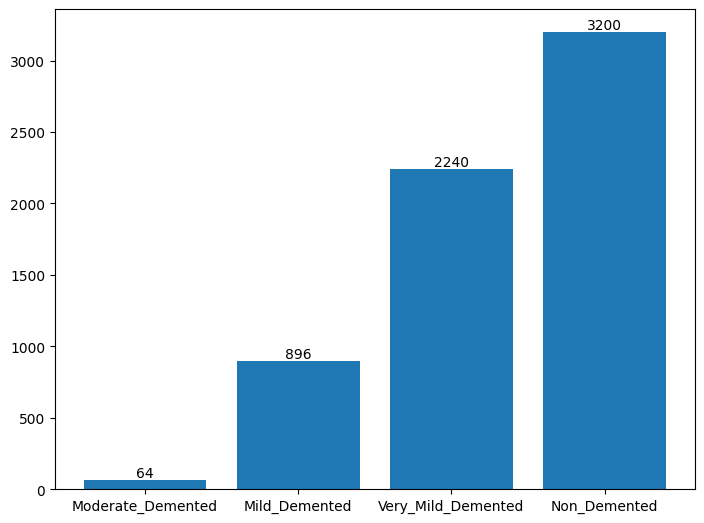

In [2]:
# Classes we have in our data set.
data_dir = "datasets/alzheimers"
total_classes = os.listdir(data_dir)
total_classes

# Total number of images per class.
images_path = Path(data_dir)

count = {}
for c in total_classes:
    count[c] = len(os.listdir(os.path.join(images_path, c)))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bars = ax.bar(count.keys(),count.values())
ax.bar_label(bars)
plt.show()

/var/folders/mj/c96jcs7j2cq7xcjfhqjq3m2w0000gn/T/ipykernel_5947/3542874851.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


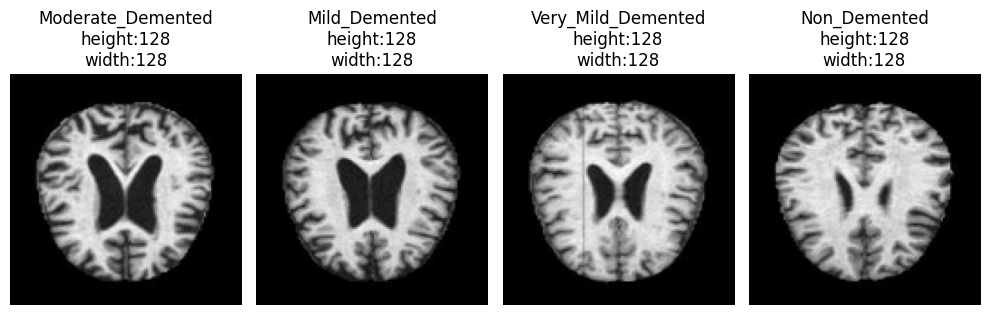

In [3]:
fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

# CNN Model

In [4]:
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [5]:
from torchsummary import summary
summary(ConvNeuralNet(4), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 12, 12]          18,496
            Conv2d-5           [-1, 64, 10, 10]          36,928
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Linear-7                  [-1, 128]         204,928
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 4]             516
Total params: 271,012
Trainable params: 271,012
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.59
Params size (MB): 1.03
Estimated Total Size (MB): 1.64
-------------------------------------------

## Train & Evaluate Model

### Hyperparameters

In [6]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 4
learning_rate = 0.001

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#total_step = len(train_loader)

### Load dataset

In [7]:
#data directory
data_dir = "./datasets/alzheimers"

# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

# Create Training dataset
#train_dataset = torchvision.datasets.ImageFolder(root = data_dir, transform = all_transforms,)

# Create Testing dataset
#test_dataset = torchvision.datasets.ImageFolder(root = data_dir, transform = all_transforms,)

dataset = torchvision.datasets.ImageFolder(root = data_dir, transform = all_transforms,)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [5000, 1400])

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

### Training

In [8]:
num_epochs = 70

# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/70], Loss: 0.9409
Epoch [2/70], Loss: 0.7084
Epoch [3/70], Loss: 0.8011
Epoch [4/70], Loss: 0.8523
Epoch [5/70], Loss: 0.9283
Epoch [6/70], Loss: 1.1114
Epoch [7/70], Loss: 0.9811
Epoch [8/70], Loss: 1.1238
Epoch [9/70], Loss: 0.9062
Epoch [10/70], Loss: 0.6923
Epoch [11/70], Loss: 0.8444
Epoch [12/70], Loss: 0.6934
Epoch [13/70], Loss: 1.0306
Epoch [14/70], Loss: 0.9815
Epoch [15/70], Loss: 1.0513
Epoch [16/70], Loss: 0.9127
Epoch [17/70], Loss: 0.8202
Epoch [18/70], Loss: 0.7233
Epoch [19/70], Loss: 0.4212
Epoch [20/70], Loss: 0.6094
Epoch [21/70], Loss: 0.8210
Epoch [22/70], Loss: 0.6954
Epoch [23/70], Loss: 0.6548
Epoch [24/70], Loss: 1.3186
Epoch [25/70], Loss: 0.7711
Epoch [26/70], Loss: 0.4566
Epoch [27/70], Loss: 0.7005
Epoch [28/70], Loss: 0.7203
Epoch [29/70], Loss: 0.7806
Epoch [30/70], Loss: 0.6576
Epoch [31/70], Loss: 0.7467
Epoch [32/70], Loss: 0.5604
Epoch [33/70], Loss: 0.4729
Epoch [34/70], Loss: 0.8124
Epoch [35/70], Loss: 0.3328
Epoch [36/70], Loss: 0.8428
E

### Testing

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} images: {} %'.format(len(test_loader.dataset), 100 * correct / total))


Accuracy of the network on the 1400 images: 95.07142857142857 %


### Save model

In [59]:
PATH = 'model.pth'
torch.save(model.state_dict(), PATH)